In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
spend = pd.read_csv('Spend.csv', sep=';')
leads = pd.read_csv('Leads.csv', sep=';')
mqls = pd.read_csv('MQLs.csv', sep=';')
opportunities= pd.read_csv('Pipeline_Opportunities.csv', sep=';')
bookings = pd.read_csv('Closed_Won_Bookings.csv', sep=';')

#### 1. How many leads, MQLS, and Opportunties and Closed Won Bookings were created each month?

In [3]:
# Convert to datetime
bookings['date'] = pd.to_datetime(bookings['Close Date'], format='%m/%d/%Y')
# Format to Month/Year
bookings['month_year'] = bookings['date'].dt.strftime('%m/%Y')
#Group by month/year
grouped_bookings = round(bookings['UTM_Campaign'].groupby(bookings['month_year']).count(),0)

In [4]:
opportunities['date'] = pd.to_datetime(opportunities['Reached Pipeline Opportunity Date'], format='%m/%d/%Y')
# Format to Month/Year
opportunities['month_year'] = opportunities['date'].dt.strftime('%m/%Y')
#Group by month/year
grouped_opportunities = round(opportunities['UTM_Campaign'].groupby(opportunities['month_year']).count(),0)

In [5]:
mqls['date'] = pd.to_datetime(mqls['Marketing Qualified Date'], format='%m/%d/%Y %I:%M %p')
# Format to Month/Year
mqls['month_year'] = mqls['date'].dt.strftime('%m/%Y')
#Group by month/year
grouped_mqls = round(mqls['UTM_Campaign'].groupby(mqls['month_year']).count(),0)

In [6]:
leads['date'] = pd.to_datetime(leads['Created Date'], format='%m/%d/%Y')
# Format to Month/Year
leads['month_year'] = leads['date'].dt.strftime('%m/%Y')
#Group by month/year
grouped_leads = round(leads['UTM_Campaign'].groupby(leads['month_year']).count(),0)

In [7]:
# Combine the results
grouped_df = pd.concat([grouped_leads, grouped_mqls, grouped_opportunities, grouped_bookings], 
                       axis=1, 
                       keys=['Leads','MQLs', 'Pipeline_Opportunities', 'Closed_Won_Bookings']).reset_index()

In [8]:
grouped_df['Leads'] = grouped_df['Leads'].astype('Int64')
grouped_df['MQLs'] = grouped_df['MQLs'].astype('Int64')
grouped_df['Closed_Won_Bookings'] = grouped_df['Closed_Won_Bookings'].astype('Int64')

In [9]:
grouped_df = grouped_df.rename(columns={'month_year':'Month'})
grouped_df['Month'] = pd.to_datetime(grouped_df['Month'], format='%m/%Y')
grouped_df = grouped_df.sort_values(by='Month')

In [10]:
#Removing the outlier 
c = grouped_df['Month'] != '2023-12-01'
df_1 = grouped_df.loc[c,]
df_1.set_index('Month', inplace=True)

In [11]:
grouped_df.set_index('Month', inplace=True)
grouped_df

,Leads,MQLs,Pipeline_Opportunities,Closed_Won_Bookings
Month,,,,
2022-11-01,296,118,9,2
2022-12-01,1294,122,15,2
2023-01-01,672,193,29,5
2023-12-01,<NA>,<NA>,1,<NA>


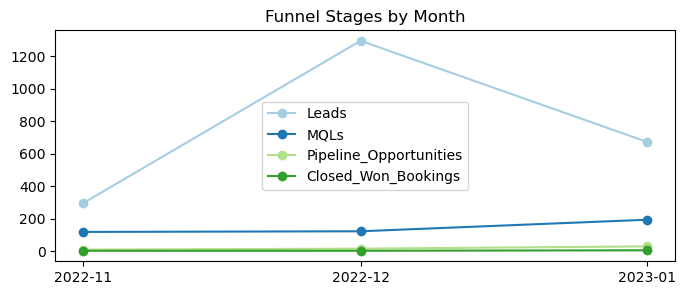

In [12]:
palette = 'Paired'
sns.set_palette(palette)


plt.figure(figsize=(8, 3))
for column in df_1.columns:
    plt.plot(df_1.index, df_1[column], marker='o', label=column)

plt.title('Funnel Stages by Month')
plt.legend()
plt.xticks(df_1.index, labels=df_1.index.strftime('%Y-%m'))  # Formatting x-axis labels for readability
plt.grid(False)
plt.show()

#### 2. How many leads, MQLS, and Opportunties were created for the account owner territories?  If account owner territory = blank, it is unmatched.  Also normalize the data by Segment (i.e. X Enterprise, X Emerging, X Scale, X SMB) 

In [13]:
# Categories and keywords
categories = {'Enterprise': ['Enterprise'],
              'Emerging': ['Emerging'],
              'Scale': ['Scale'],
              'SMB': ['SMB'],}

In [14]:
# Function to assign category
def assign_category(row):
    if pd.isna(row):  
        return 'Unmatched'  
    for category, keywords in categories.items():
        if any(keyword in row for keyword in keywords):
            return category
    return 'Other'

In [15]:
# Apply the function
leads['Segment'] = leads['Account Owner Territory'].apply(assign_category)
mqls['Segment'] = mqls['Account Owner Territory'].apply(assign_category)
opportunities['Segment'] = opportunities['Account Owner Territory'].apply(assign_category)

In [16]:
leads_seg = leads['Segment'].value_counts()
mqls_seg = mqls['Segment'].value_counts()
opportunities_seg = opportunities['Segment'].value_counts()

In [17]:
df_seg = pd.DataFrame({'Leads': leads_seg, 'MQLs': mqls_seg, 'Opportunities': opportunities_seg}).reset_index()
df_seg = df_seg.rename(columns={'index':'Segment'})
df_seg.reset_index(drop=True, inplace=True)

In [18]:
df_seg

,Segment,Leads,MQLs,Opportunities
0,Emerging,606,109,8.0
1,Enterprise,500,73,8.0
2,Other,48,4,1.0
3,SMB,106,94,28.0
4,Scale,161,49,9.0
5,Unmatched,841,104,NaN


In [19]:
# Melting the DataFrame to create the chart
df_melted = df_seg.melt(id_vars='Segment', var_name='Metric', value_name='Value')

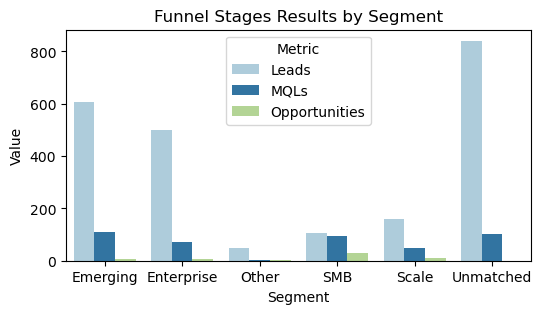

In [20]:
plt.figure(figsize=(6, 3))
bar_plot = sns.barplot(x='Segment', y='Value', hue='Metric', data=df_melted, palette="Paired")

plt.title('Funnel Stages Results by Segment')
plt.show()

#### 3. Provide a paid media channel split for each funnel stage (Leads, MQLs, Pipeline Opportunties and CW Bookings) 

In [21]:
# Renaming for alignment
categories_mapping = {
    'paid-content-syndication': 'Content Syndication',
    'paid-display-ads': 'Paid Display',
    'paid-remarketing': 'Remarketing',
    'paid-search': 'Paid Search',
    'paid-social': 'Paid Social'
}

In [22]:
mqls_funnel = mqls['UTM_Medium'].value_counts()

In [23]:
opportunities_funnel = opportunities['UTM_Medium'].value_counts()

In [24]:
bookings_funnel = bookings['UTM_Medium'].value_counts()

In [25]:
leads_funnel = leads['UTM_Medium'].value_counts()

In [26]:
df_funnel = pd.DataFrame({'Leads': leads_funnel, 
                          'MQLs': mqls_funnel, 
                          'Opportunities': opportunities_funnel,
                          'Bookings': bookings_funnel
                         })
df_funnel = df_funnel.reset_index()

In [27]:
df_funnel = df_funnel.rename(columns={'UTM_Medium':'Channel'})

In [28]:
#rename categories
df_funnel['Channel'] = df_funnel['Channel'].replace(categories_mapping)

In [29]:
df_funnel

,Channel,Leads,MQLs,Opportunities,Bookings
0,Content Syndication,1260,150.0,4.0,1.0
1,Paid Display,5,1.0,NaN,NaN
2,Remarketing,1,NaN,NaN,NaN
3,Paid Search,635,243.0,44.0,7.0
4,Paid Social,361,39.0,6.0,1.0


In [30]:
# Melting the DataFrame to create the chart
df_melted2 = df_funnel.melt(id_vars='Channel', var_name='Metric', value_name='Value')

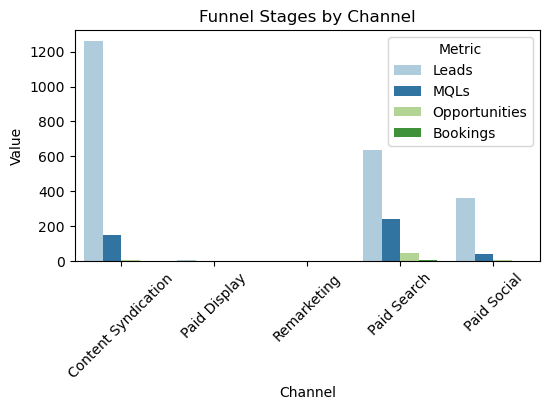

In [31]:
plt.figure(figsize=(6, 3))
bar_plot = sns.barplot(x='Channel', y='Value', hue='Metric', data=df_melted2, palette="Paired")

plt.title('Funnel Stages by Channel')
plt.xticks(rotation=45)
plt.show()

#### 4. By channel, how many MQLs were handraisers? (1 = true, 0 = false)

In [32]:
handraisers_by_channel = mqls.groupby('UTM_Medium')['Hand Raiser'].sum().reset_index(name='Handraisers')
handraisers_by_channel.sort_values('Handraisers', ascending=False, inplace=True)
handraisers_by_channel = handraisers_by_channel.rename(columns={'UTM_Medium': 'Channel'})
handraisers_by_channel['Channel'] = handraisers_by_channel['Channel'].replace(categories_mapping)
handraisers_by_channel

,Channel,Handraisers
2,Paid Search,210
0,Content Syndication,4
3,Paid Social,3
1,Paid Display,0


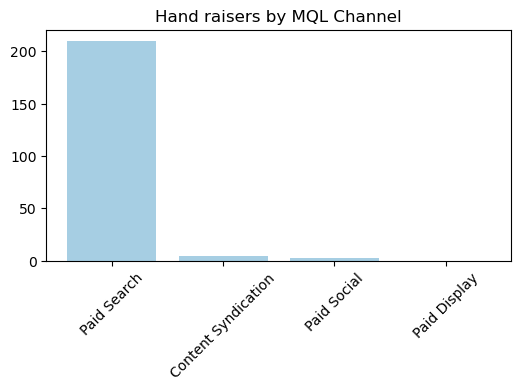

In [33]:
plt.figure(figsize=(6, 3))
plt.bar(handraisers_by_channel['Channel'], handraisers_by_channel['Handraisers'].sort_values(ascending=False)) 

plt.title('Hand raisers by MQL Channel')
plt.xticks(rotation=45) 
plt.show()

#### 5. For each channel, identify the following:  Lead to MQL conversion rate,  MQL to Pipeline Opportunity Conversion Rate, and the Pipeline Opportunity to Close Won Booking Conversion Rate

In [34]:
df_conv_rate = df_funnel

In [35]:
# Calculating Lead to MQL conversion rate
df_conv_rate['convrate_lead_mql'] = round((df_conv_rate['MQLs'] / df_conv_rate['Leads']) * 100)

In [36]:
# Calculating MQL to Pipeline conversion rate
df_conv_rate['convrate_mql_pipeline'] = round((df_conv_rate['Opportunities'] / df_conv_rate['MQLs']) * 100)

In [37]:
# Calculating Pipeline to Booking conversion rate
df_conv_rate['convrate_pipeline_booking'] = round((df_conv_rate['Bookings'] / df_conv_rate['Opportunities']) * 100)

In [38]:
df_conv_rate = df_conv_rate[['Channel','convrate_lead_mql', 'convrate_mql_pipeline', 'convrate_pipeline_booking']]

In [39]:
df_conv_rate = df_conv_rate.fillna(0)
df_conv_rate['Channel'] = df_conv_rate['Channel'].replace(categories_mapping)
df_conv_rate

,Channel,convrate_lead_mql,convrate_mql_pipeline,convrate_pipeline_booking
0,Content Syndication,12.0,3.0,25.0
1,Paid Display,20.0,0.0,0.0
2,Remarketing,0.0,0.0,0.0
3,Paid Search,38.0,18.0,16.0
4,Paid Social,11.0,15.0,17.0


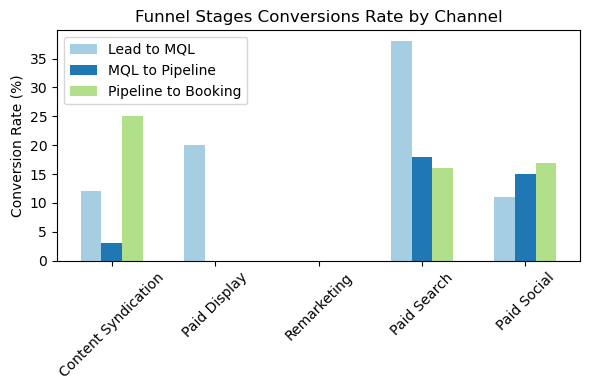

In [40]:
n_channels = len(df_conv_rate['Channel'])

# Setting the positions for the bars
ind = np.arange(n_channels)  # the x locations for the groups
width = 0.2 # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

bars1 = ax.bar(ind - width, df_conv_rate['convrate_lead_mql'], width, label='Lead to MQL')
bars2 = ax.bar(ind, df_conv_rate['convrate_mql_pipeline'], width, label='MQL to Pipeline')
bars3 = ax.bar(ind + width, df_conv_rate['convrate_pipeline_booking'], width, label='Pipeline to Booking')

ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Funnel Stages Conversions Rate by Channel')
ax.set_xticks(ind)
ax.set_xticklabels(df_conv_rate['Channel'])
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 6. For each channel, identify the following:  Cost per lead, cost per MQL, cost per Opportunity, cost per Closed Won booking

In [41]:
# Convert Spend to numeric
spend['Spend'] = spend['Spend'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float)

In [42]:
#rename categories
df_funnel['Channel'] = df_funnel['Channel'].replace(categories_mapping)

In [43]:
spend['Channel'] = spend['Channel'].replace({'Content Syndication ':'Content Syndication'})

In [44]:
df_funnel = df_funnel[['Channel', 'Leads', 'MQLs', 'Opportunities', 'Bookings']]

In [45]:
spend = spend[['Channel', 'Spend']]

In [46]:
merged_df = pd.merge(spend, df_funnel, on='Channel', how='left')

In [47]:
merged_df = merged_df.sort_values('Channel')

In [48]:
# Calculate cost per metrics
merged_df['Cost_per_Lead'] = merged_df['Spend'] / merged_df['Leads']
merged_df['Cost_per_MQL'] = merged_df['Spend'] / merged_df['MQLs']
merged_df['Cost_per_Pipeline'] = merged_df['Spend'] / merged_df['Opportunities']
merged_df['Cost_per_Booking'] = merged_df['Spend'] / merged_df['Bookings']

In [49]:
merged_df = merged_df[['Channel', 'Spend','Cost_per_Lead', 'Cost_per_MQL','Cost_per_Pipeline', 'Cost_per_Booking']]

In [50]:
merged_df = merged_df.fillna(0)

In [51]:
round(merged_df, 2)

,Channel,Spend,Cost_per_Lead,Cost_per_MQL,Cost_per_Pipeline,Cost_per_Booking
0,Content Syndication,100000.0,79.37,666.67,25000.00,100000.00
3,Paid Display,30000.0,6000.00,30000.00,0.00,0.00
2,Paid Search,435000.0,685.04,1790.12,9886.36,62142.86
1,Paid Social,111349.0,308.45,2855.10,18558.17,111349.00


In [52]:
merged_df.drop('Spend', axis=1, inplace=True)

In [53]:
merged_df['Total'] = merged_df[['Cost_per_Lead', 'Cost_per_MQL', 'Cost_per_Pipeline', 'Cost_per_Booking']].sum(axis=1)

In [54]:
# Sorting the DataFrame by Total in descending order
sorted_df = merged_df.sort_values(by='Total', ascending=False)

In [55]:
sorted_df.drop('Total', axis=1, inplace=True)

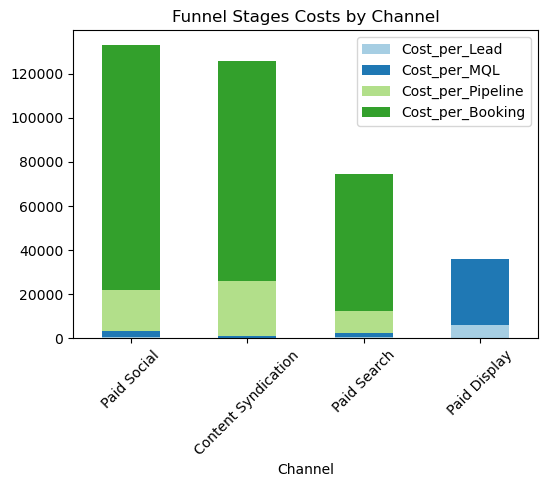

In [56]:
ax = sorted_df.set_index('Channel').plot(kind='bar', stacked=True, figsize=(6, 4))

plt.title('Funnel Stages Costs by Channel')
plt.xticks(rotation=45) 
plt.show()

#### 7. Which utm_campaign generated the most new leads, the most new MQLS and the most new Opportunties?

In [57]:
leads_camp = leads['UTM_Campaign'].value_counts().head(1)

In [58]:
mqls_camp = mqls['UTM_Campaign'].value_counts().head(1)

In [59]:
opportunities_camp = opportunities['UTM_Campaign'].value_counts().head(1)

In [60]:
df_campaigns = pd.DataFrame({'Leads': leads_camp, 
                          'MQLs': mqls_camp, 
                          'Opportunities': opportunities_camp
                         })
df_campaigns = df_campaigns.reset_index()

In [61]:
df_campaigns = df_campaigns.fillna(0)
df_campaigns = df_campaigns.rename(columns={'index': 'UTM_Campaign'})

In [62]:
df_campaigns

,UTM_Campaign,Leads,MQLs,Opportunities
0,fy22-amer-brand_l_brand,0.0,0.0,28.0
1,fy22-amer-email_marketing_platform,0.0,81.0,0.0
2,fy23-q4-amer-customer_engagement_review_canada,330.0,0.0,0.0


#### 8. What is the pipeline to spend ratio for each channel?

In [63]:
opportunities['Pipeline Amount'] = opportunities['Pipeline Amount'].replace({',': ''}, regex=True).astype(float)

pipeline_amount_by_channel = opportunities.groupby('UTM_Medium')['Pipeline Amount'].sum()

In [64]:
teste = pd.DataFrame({'Pipeline Amount': pipeline_amount_by_channel})
teste = teste.reset_index()

In [65]:
teste['UTM_Medium'] = teste['UTM_Medium'].replace(categories_mapping)

In [66]:
pipeline = merged_df[['Channel']]
pipeline = pipeline.rename(columns={'Channel': 'UTM_Medium'})

In [67]:
fd_spend_ratio_pip = pd.merge(pipeline, teste, on='UTM_Medium', how='left')
fd_spend_ratio_pip = fd_spend_ratio_pip.fillna(0)

In [68]:
fd_spend_ratio_pip = pd.merge(fd_spend_ratio_pip, spend, left_on='UTM_Medium', right_on='Channel', how='left')

In [69]:
fd_spend_ratio_pip['Pipeline Spend Ratio'] = round(fd_spend_ratio_pip['Pipeline Amount']/fd_spend_ratio_pip['Spend'])

In [70]:
fd_spend_ratio_pip = fd_spend_ratio_pip[['Channel', 'Pipeline Amount', 'Spend','Pipeline Spend Ratio']]
fd_spend_ratio_pip = fd_spend_ratio_pip.sort_values('Pipeline Spend Ratio', ascending=False)
fd_spend_ratio_pip

,Channel,Pipeline Amount,Spend,Pipeline Spend Ratio
2,Paid Search,78343625.0,435000.0,180.0
0,Content Syndication,1039082.0,100000.0,10.0
3,Paid Social,438704.0,111349.0,4.0
1,Paid Display,0.0,30000.0,0.0


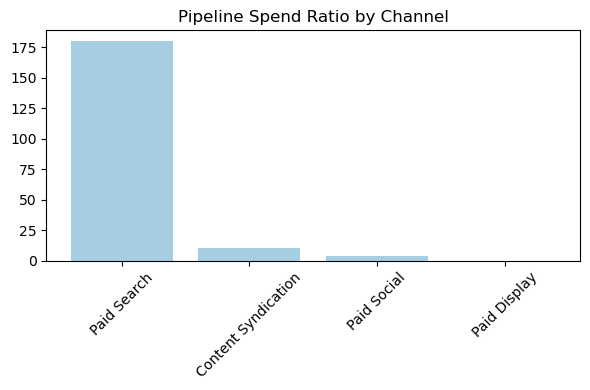

In [71]:
plt.figure(figsize=(6, 4))
plt.bar(fd_spend_ratio_pip['Channel'], fd_spend_ratio_pip['Pipeline Spend Ratio'].sort_values(ascending=False))

plt.title('Pipeline Spend Ratio by Channel')
plt.xticks(rotation=45) 

plt.tight_layout()  
plt.show()

#### 9. What is the the ROI for each channel?

In [72]:
bookings['Closed Won Bookings Amount'] = bookings['Closed Won Bookings Amount'].replace({',': ''}, regex=True).astype(float)

In [73]:
closed_won_amount_by_channel = bookings.groupby('UTM_Medium')['Closed Won Bookings Amount'].sum()

In [74]:
roi = pd.DataFrame({'Closed Won Bookings Amount': closed_won_amount_by_channel})
roi = roi.reset_index()
roi['UTM_Medium'] = roi['UTM_Medium'].replace(categories_mapping)

In [75]:
spend = spend.rename(columns={'Channel': 'UTM_Medium'})

In [76]:
roi_df = pd.merge(roi, spend, on='UTM_Medium', how='left')

In [77]:
roi_df['ROI %'] = round(((roi_df['Closed Won Bookings Amount'] - roi_df['Spend']) / roi_df['Spend']) * 100, 2)

In [78]:
roi_df = roi_df[['UTM_Medium', 'ROI %']]
roi_df = roi_df.rename(columns={'UTM_Medium':'Channel'})
roi_df = roi_df.sort_values('ROI %', ascending=False)
roi_df

,Channel,ROI %
1,Paid Search,789.3
0,Content Syndication,415.0
2,Paid Social,-75.0


A positive ROI indicates a profitable return, whereas a negative ROI indicates a loss relative to the spend on that channel.

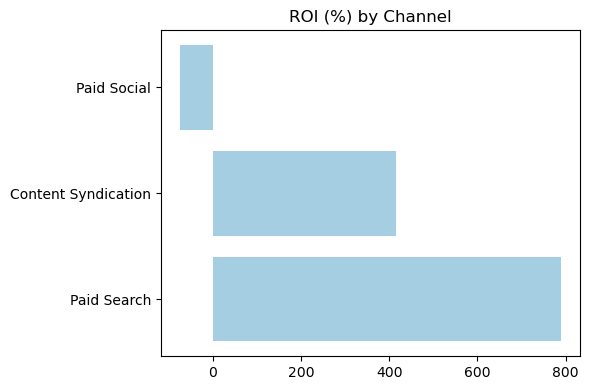

In [79]:
plt.figure(figsize=(6, 4))
plt.barh(roi_df['Channel'], roi_df['ROI %'])

plt.title('ROI (%) by Channel')
plt.tight_layout()  
plt.show()

#### Add any additional data analysis that you think is worth including. 

#### 10. Average Deal Size by Channel: Understanding the average size of closed won bookings to analyze which channels tend to bring larger deals.

In [80]:
avg_deal_size = round(bookings.groupby('UTM_Medium')['Closed Won Bookings Amount'].mean().reset_index())

In [81]:
avg_deal_size =avg_deal_size.rename(columns={'UTM_Medium': 'Channel', 'Closed Won Bookings Amount': 'Avg Deal Size'})

In [82]:
avg_deal_size = avg_deal_size.sort_values('Avg Deal Size', ascending= False)

In [83]:
#rename categories
avg_deal_size['Channel'] = avg_deal_size['Channel'].replace(categories_mapping)

In [84]:
avg_deal_size

,Channel,Avg Deal Size
1,Paid Search,552634.0
0,Content Syndication,515000.0
2,Paid Social,27842.0


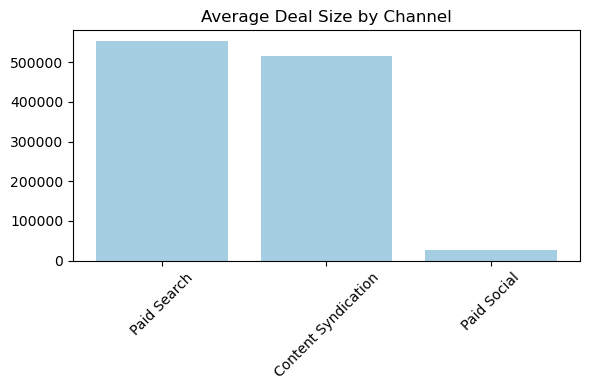

In [85]:
plt.figure(figsize=(6, 4))
plt.bar(avg_deal_size['Channel'], avg_deal_size['Avg Deal Size'].sort_values(ascending=False))

plt.title('Average Deal Size by Channel')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()